In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('hpd_final_two.csv')
df = df.dropna()
df["Date"]=pd.to_datetime(df["Date"])
df["Date"] = df["Date"].dt.strftime('%Y-%m')
df.sort_values(by=['Date'], inplace=True, ascending=True)
df = df.set_index('Date')

categories = df.Product_Category.unique()
df

,Product_Code,Warehouse,Product_Category,Order_Demand,Customer_Code,Customer_Zip,Customer_City,Customer_State,Customer_Region,Customer_Country,Customer_Type
Date,,,,,,,,,,,
2011-01,Product_0982,Whse_A,Category_028,4500,CC19299,713301,Asansol,West Bengal,east,India,Internal_goods
2011-01,Product_0981,Whse_A,Category_028,50,CC15711,734001,Siliguri,West Bengal,east,India,Wholesale
2011-01,Product_1102,Whse_S,Category_004,1200,CC12253,601021,Kollam,Kerala,south,India,Internal_goods
2011-02,Product_1507,Whse_C,Category_019,1250,CC19300,111045,Pune,Maharastra,west,India,Internal_goods
2011-02,Product_0981,Whse_A,Category_028,2500,CC15832,831001,Jamshedpur,Jharkhand,east,India,Internal_goods
...,...,...,...,...,...,...,...,...,...,...,...
2017-06,Product_0689,Whse_J,Category_011,300,CC13994,226001,Lucknow,UP,north,India,Wholesale
2017-06,Product_0689,Whse_J,Category_011,200,CC15287,223007,Agra,UP,north,India,Internal_goods
2017-09,Product_0471,Whse_C,Category_015,30,CC13965,230532,Mumbai,Maharastra,west,India,Retail


In [ ]:

region_dict = dict()
regions = df.groupby('Customer_Region')
for region, group in regions:
    cat_dict = dict()
    cat = group.groupby('Product_Category')
    for name, obj in cat:
        cat_dict[name] = obj
    region_dict[region] = cat_dict


In [ ]:
from scipy import stats
s=0
for region, category_obj in region_dict.items():
    print(region.upper(),'\n')
    print('Category Name\tPrevious\tLater\tOutliers\tMax Threshold')
    for name, obj in category_obj.items():
        prev = len(obj.Order_Demand)
        obj = obj[np.abs(stats.zscore(obj.Order_Demand)) < 3]
        lat = len(obj.Order_Demand)
        print('{0}\t{1}\t\t{2}\t  {3}'.format(name,prev,lat,prev-lat))
        region_dict[region][name] = obj
        s+= prev-lat
    print()

print('Total Outliers:',s)

EAST 

Category Name	Previous	Later	Outliers	Max Threshold
Category_001	127		125	  2
Category_003	1941		1911	  30
Category_005	1519		1483	  36
Category_006	3920		3823	  97
Category_007	15058		14821	  237
Category_008	168		165	  3
Category_009	7480		7359	  121
Category_010	737		722	  15
Category_011	799		779	  20
Category_012	213		206	  7
Category_013	1118		1097	  21
Category_015	5687		5621	  66
Category_016	18		18	  0
Category_017	245		240	  5
Category_018	2633		2569	  64
Category_019	62556		61647	  909
Category_021	13585		13377	  208
Category_022	979		957	  22
Category_023	340		334	  6
Category_024	6692		6633	  59
Category_026	3345		3292	  53
Category_027	26		25	  1
Category_028	11158		11028	  130
Category_029	671		650	  21
Category_031	1315		1287	  28

NORTH 

Category Name	Previous	Later	Outliers	Max Threshold
Category_001	93013		91514	  1499
Category_003	1399		1370	  29
Category_005	91215		90172	  1043
Category_006	27533		27181	  352
Category_007	55192		54704	  488
Category_008	137

In [ ]:
from statsmodels.tsa.stattools import adfuller
def isSeriesStationary(series):
    pValue = adfuller(series)[1]
    if pValue > 0.05:
        return False
    else:
        return True

In [ ]:
def isSeriesStationaryAvg(series, delta = 2):
    split = int(len(series)/2)
    print(split)
    split1, split2 = series[:split], series[split:]
    avg1, avg2 = split1.mean(), split2.mean()
    var1, var2 = split1.var(), split2.var()
    if abs(avg1 - avg2) > delta or abs(var1 - var2) > delta**2:
        return False
    else:
        return True

# Parameter Selection for the SARIMA Time Series Model

In [ ]:
import itertools    
q = d = range(0, 2)
p = range(0, 4)

#p = d = q = range(0, 3)


pdq = list(itertools.product(p, d, q))

seasonal = int(input("ENTER THE SEASONAL COMPONENT VALUE\n"))

seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

ENTER THE SEASONAL COMPONENT VALUE
4
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 4)
SARIMAX: (0, 0, 1) x (0, 1, 0, 4)
SARIMAX: (0, 1, 0) x (0, 1, 1, 4)
SARIMAX: (0, 1, 0) x (1, 0, 0, 4)


# Fitting SARIMA model into train dataset

In [ ]:

import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

reg=input("ENTER REGION\n")
cat=input("ENTER CATEGORY\n")

for region, category_obj  in region_dict.items():
    if reg==region:
        for name, obj in category_obj.items():
            if cat==name: 
                AIC = []
                parm_ = []
                parm_s = []
                for param in pdq:
                    for param_seasonal in seasonal_pdq:
                        try:
                            mod = sm.tsa.statespace.SARIMAX(obj.Order_Demand,order=param,seasonal_order=param_seasonal,
                                                            enforce_stationarity=False,enforce_invertibility=False)

                            results = mod.fit()
                            AIC.append(results.aic)
                            parm_.append(param)
                            parm_s.append(param_seasonal)

                            print('ARIMA{}x{}seasonal - AIC:{}'.format(param, param_seasonal, results.aic))
                        except:
                            continue

ENTER REGION
east
ENTER CATEGORY
Category_018
ARIMA(0, 0, 0)x(0, 0, 0, 4)seasonal - AIC:19424.77268139793
ARIMA(0, 0, 0)x(0, 0, 1, 4)seasonal - AIC:19025.992626283143
ARIMA(0, 0, 0)x(0, 1, 0, 4)seasonal - AIC:19548.173543924007
ARIMA(0, 0, 0)x(0, 1, 1, 4)seasonal - AIC:17674.586458426984
ARIMA(0, 0, 0)x(1, 0, 0, 4)seasonal - AIC:18767.589346449677
ARIMA(0, 0, 0)x(1, 0, 1, 4)seasonal - AIC:17706.550012573185
ARIMA(0, 0, 0)x(1, 1, 0, 4)seasonal - AIC:18703.807006178708
ARIMA(0, 0, 0)x(1, 1, 1, 4)seasonal - AIC:17672.021589437674
ARIMA(0, 0, 0)x(2, 0, 0, 4)seasonal - AIC:18398.559903228066
ARIMA(0, 0, 0)x(2, 0, 1, 4)seasonal - AIC:17683.60676512565
ARIMA(0, 0, 0)x(2, 1, 0, 4)seasonal - AIC:18378.39708223052
ARIMA(0, 0, 0)x(2, 1, 1, 4)seasonal - AIC:17653.745963436566
ARIMA(0, 0, 0)x(3, 0, 0, 4)seasonal - AIC:18211.71945614239
ARIMA(0, 0, 0)x(3, 0, 1, 4)seasonal - AIC:17658.131285250107
ARIMA(0, 0, 0)x(3, 1, 0, 4)seasonal - AIC:18126.224261207288
ARIMA(0, 0, 0)x(3, 1, 1, 4)seasonal - AIC:1

In [ ]:
min(AIC)

17604.528882853323

In [ ]:
pos = AIC.index(min(AIC))

In [ ]:
parm_[pos]

(3, 1, 1)

In [ ]:
parm_s[pos]

(3, 0, 0, 4)

In [ ]:
def splitTrainTest(series, testSplit):
    totalData = len(series)
    trainSplit = int(totalData * (1 - testSplit))
    trainSet = series[:trainSplit]
    testSet = series[trainSplit:]
    return trainSet, testSet

In [ ]:
reg=input("ENTER REGION\n")
cat=input("ENTER CATEGORY\n")

for region, category_obj  in region_dict.items():
    if reg==region:
        for name, obj in category_obj.items():
            if cat==name: 
                trainSet, testSet = splitTrainTest(obj.Order_Demand, 0.3)
                mod_a = sm.tsa.statespace.SARIMAX(obj.Order_Demand,order=parm_[pos],seasonal_order=parm_s[pos]
                                                  ,enforce_stationarity=False
                                                  ,enforce_invertibility=False)
          
         
                #od_a = sm.tsa.statespace.SARIMAX(trainSet,order=parm_[pos],seasonal_order=parm_s[pos]
                #                                 ,enforce_stationarity=False
                #                                 ,enforce_invertibility=False)
                
print(trainSet.shape)
result = mod_a.fit()
print(result.summary().tables[1])
testSet.head()
#testSet.tail()




ENTER REGION
east
ENTER CATEGORY
Category_018
(1798,)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0132      0.018      0.716      0.474      -0.023       0.049
ar.L2         -0.0029      0.019     -0.158      0.874      -0.039       0.033
ar.L3          0.0233      0.020      1.151      0.250      -0.016       0.063
ma.L1         -0.9912      0.003   -355.695      0.000      -0.997      -0.986
ar.S.L4       -0.0511      0.021     -2.442      0.015      -0.092      -0.010
ar.S.L8       -0.0022      0.020     -0.107      0.915      -0.042       0.038
ar.S.L12      -0.0199      0.020     -0.993      0.321      -0.059       0.019
sigma2        57.4070      1.030     55.743      0.000      55.388      59.425


Date
2015-09     3
2015-09     3
2015-09    10
2015-09    20
2015-09    10
Name: Order_Demand, dtype: int64

# Order Demand Prediction

In [ ]:

predictions = result.predict(start='2015-09',dynamic=False)
print(testSet.values)
print(predictions.values)


[ 3  3 10 20 10  2  1  4  2  6  5 10  3 10  2  4 10  1  3 20 20 10  1  1
  6  1 20 10 15 10 20  3 19  9 20 20  2 10  3  4  6 30 30 10  2 10  1 10
  2 15 10  1  6 30 20  2 10  1  8 10  2 11 30  8  1 10  1 20 30  1 10  6
 10 20  8 20 11  8  5  3  4  3  3  2  1  1  1 10 10  4 10 12  6 10 10 10
  6 20  6 10  1 15 20  4 28  1 20 32  1  2 30  3  5  1  1  8  3 30 10  2
 10 10  1  1  3  2 12  2  8  4 10  1  5  6  8  5  2 19  3 10 10  2  4  5
 10  2  2 20  1 20 10  1  4 10 12 20  2 10  3  1  1  4  5  1  1  1  1 20
  1 20  4 25  1  1  2 20 40  1  3 20  1  3 14  1  7 10 20  2 10  5  1  5
  6  1  1  6 30  1  1 10 10 10  2 10 10  2  5  1  1  3 15  4  6  5 10 10
 30 10  2  1  8  1  2  4  2  5 20  4  7  5 10 10  1  5 10  1 14  1  5  1
 14  3  5 10  2  5 10 10  1 20 10  1  7  3 20 10 20  1 10  1 10  4  6 15
  1  2  1  1 20  1  4  3  5  9  1 10 10  1  4 15 10  1 10  4 20 10  1 16
  2 10  4  1  1 10  4 10  7  8  2  2  1 15 10  2  4 10 12 40  5  1  5  3
  3 20  1  1  1  3  2  4 10 10  1 20 15  4  1  1 20

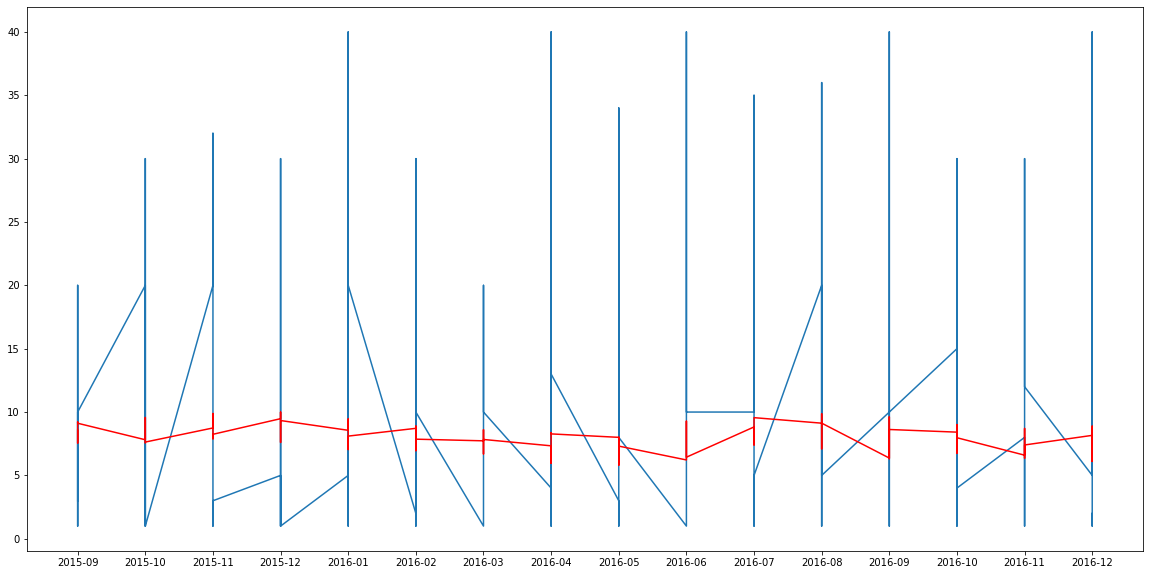

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(testSet)
plt.plot(predictions, color='red')
plt.show()